# Preprocessing

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import random
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

import os, sys

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cpu


In [2]:
# changing core directory

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('..')
%ls

config_examples/  datasets/  notebooks/  README.md  source/


In [3]:
from source.training.early_stopping import EarlyStopping
from source.data.power_cons import load_powercons, PowerConsDataset

# from source.training.activation import Activation

from source.classifiers.LSTM_Classifier import LSTMClassifier
from source.classifiers.ResCNN_Classifier import ResCNNClassifier

In [4]:
SEED = 1000
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
TRAIN_PATH = Path('datasets/PowerCons_TRAIN.tsv')
TEST_PATH = Path('datasets/PowerCons_TEST.tsv')
BATCH_SIZE = 64

# Dataset preparation

In [8]:
X_train, y_train, classes_ = load_powercons(TRAIN_PATH)
X_test, y_test, _ = load_powercons(TEST_PATH)
n_classes = len(classes_)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape, 'n_classes:', n_classes)

Train shape: (180, 144, 1) Test shape: (180, 144, 1) n_classes: 2


In [9]:
print(X_train.min(), X_train.max(), X_test.min(), X_test.max())

-1.6031435 6.4025993 -1.6804967 5.9844995


In [10]:
train_ds = PowerConsDataset(X_train, y_train)
test_ds = PowerConsDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

counts:
1    90
2    90
Name: 0, dtype: int64
shares:
1    0.5
2    0.5
Name: 0, dtype: float64


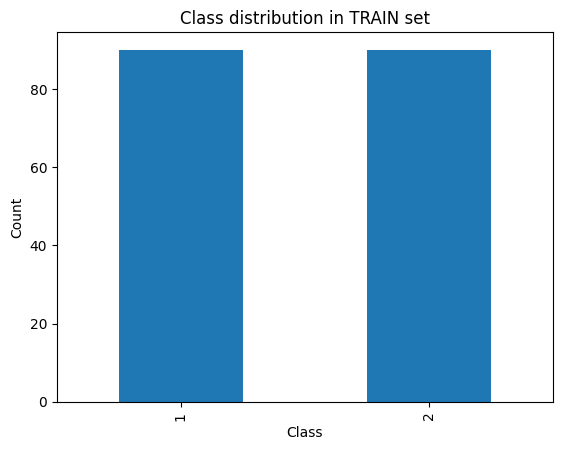

In [11]:
# check data-balance

df = pd.read_csv(TRAIN_PATH, sep='\t', header=None)

# 1. Считаем количество примеров каждого класса
label_counts = df.iloc[:, 0].value_counts().sort_index()
print(f'counts:\n{label_counts}')                # абсолютные значения
print(f'shares:\n{label_counts / len(df)}')      # доли

# 2. Быстрый бар-чарт
label_counts.plot.bar()
plt.title('Class distribution in TRAIN set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [12]:
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g)

# Classifiers